In [ ]:
# Configuração do ambiente gráfico virtual (se necessário)
!apt-get install -y xvfb x11-utils

# Instale o Gym e outras dependências
!pip install gym[atari] stable-baselines3 opencv-python gym[accept-rom-license] pyvirtualdisplay

# Instale o PyTorch com suporte CUDA (ajuste a versão CUDA conforme sua necessidade)
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117


In [8]:
import os
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import datetime
import glob
import matplotlib.pyplot as plt
from collections import deque
from pyvirtualdisplay import Display
import cv2


In [9]:
display = Display(visible=0, size=(1400, 900))
display.start()
torch.backends.cudnn.benchmark = True
# Inicializar o modelo
device = torch.device("cuda")
print(device)

def preprocess_frame(frame):
    # Converte de RGB para escala de cinza e redimensiona
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame_resized = cv2.resize(frame_gray, (84, 84))
    frame_normalized = (frame_resized / 255.0 - 0.5) * 2  # Normaliza para [-1,1]
    # Converte para tensor e move para GPU
    frame_tensor = torch.tensor(frame_normalized, dtype=torch.float32, device=device)
    return frame_tensor

# Função para empilhar frames. Aqui, os frames já são tensores na GPU.
def stack_frames(stacked_frames, new_frame, is_new_episode, stack_size=4):
    if is_new_episode or stacked_frames is None:
        stacked_frames = [new_frame for _ in range(stack_size)]
    else:
        stacked_frames.pop(0)
        stacked_frames.append(new_frame)
    # Retorna um tensor com shape [stack_size, H, W] e a lista atualizada
    return torch.stack(stacked_frames, dim=0), stacked_frames





# Criar ambiente Atari
env = gym.make("ALE/Pacman-v5", render_mode='rgb_array',max_episode_steps=5000)

# Teste de preprocessamento
obs = env.reset()[0]  # Usa o primeiro elemento da tupla
processed_frame = preprocess_frame(obs)

cuda


In [14]:


class DQNWithEnhancedMLP(nn.Module):
    def __init__(self, action_size):
        super(DQNWithEnhancedMLP, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.mlp = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 256),  # Camadas extras
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        x = self.cnn(x)
        return self.mlp(x)

In [ ]:
model = DQNWithEnhancedMLP(env.action_space.n).to(device)

# Carrega modelo salvo, se existir
model_dir = "/content/drive/MyDrive/Salvo do Chrome/DqnModel"
model_paths = glob.glob(os.path.join(model_dir, 'dqn_model_*.pth'))
if model_paths:
    latest_model_path = max(model_paths, key=os.path.getctime)
    print(f"Carregando modelo salvo de {latest_model_path}")
    model.load_state_dict(torch.load(latest_model_path, map_location=device), strict=False)
    model.eval()
else:
    print("Nenhum modelo salvo encontrado. Treino começará do zero.")

def select_action(state, model, epsilon=0.1):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            # state já é um tensor na GPU
            return model(state.unsqueeze(0)).argmax().item()

# Parâmetros de treinamento
num_episodes = 1000
gamma = 0.99
learning_rate = 0.00005
epsilon = 1.0
epsilon_min = 0.2
epsilon_decay = 0.98
buffer_size = 100000
# Aumentando o tamanho do batch para 256
batch_size = 256

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
memory = deque(maxlen=buffer_size)
rewardsX = []

# Treinamento com precisão mista
scaler = torch.amp.GradScaler()

for episode in range(num_episodes):
    total_reward = 0
    obs, _ = env.reset()
    state, frames = stack_frames(None, preprocess_frame(obs), True)
    done = False
    time_steps = 0

    # Valor de bônus por sobrevivência
    living_reward = 0.1
    # Penalidade por término (game over)
    game_over_penalty = -1.0

    while not done:
        action = select_action(state, model, epsilon)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state, frames = stack_frames(frames, preprocess_frame(next_obs), False)
        time_steps += 1


            # Modifica a recompensa: se o episódio continua, adiciona living_reward
        if not done:
            reward += living_reward
        else:
        # Penaliza o término do episódio
            reward += game_over_penalty

        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if len(memory) > batch_size:
            batch = random.sample(memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            # Como os estados já estão em GPU, usamos torch.stack diretamente
            states = torch.stack(states).to(device)
            actions = torch.tensor(actions, dtype=torch.int64, device=device).unsqueeze(1)
            rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
            next_states = torch.stack(next_states).to(device)
            dones = torch.tensor(dones, dtype=torch.float32, device=device)

            # Utiliza autocast para mixed precision
            with torch.autocast('cuda'):
                q_values = model(states).gather(1, actions).squeeze(1)
                next_q_values = model(next_states).max(1)[0]
                target_q_values = rewards + gamma * next_q_values * (1 - dones)
                loss = nn.MSELoss()(q_values, target_q_values.detach())

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewardsX.append(total_reward)
    print(f"Episode {episode+1}: Reward {total_reward}")

print(f"Treinamento concluído. Total de time steps: {time_steps}")

In [16]:
# Salvamento do modelo com timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_save_path = f'/content/drive/MyDrive/Salvo do Chrome/dqn_model_{timestamp}.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Modelo salvo em {model_save_path}")

Modelo salvo em /content/drive/MyDrive/Salvo do Chrome/dqn_model_20250224-204519.pth


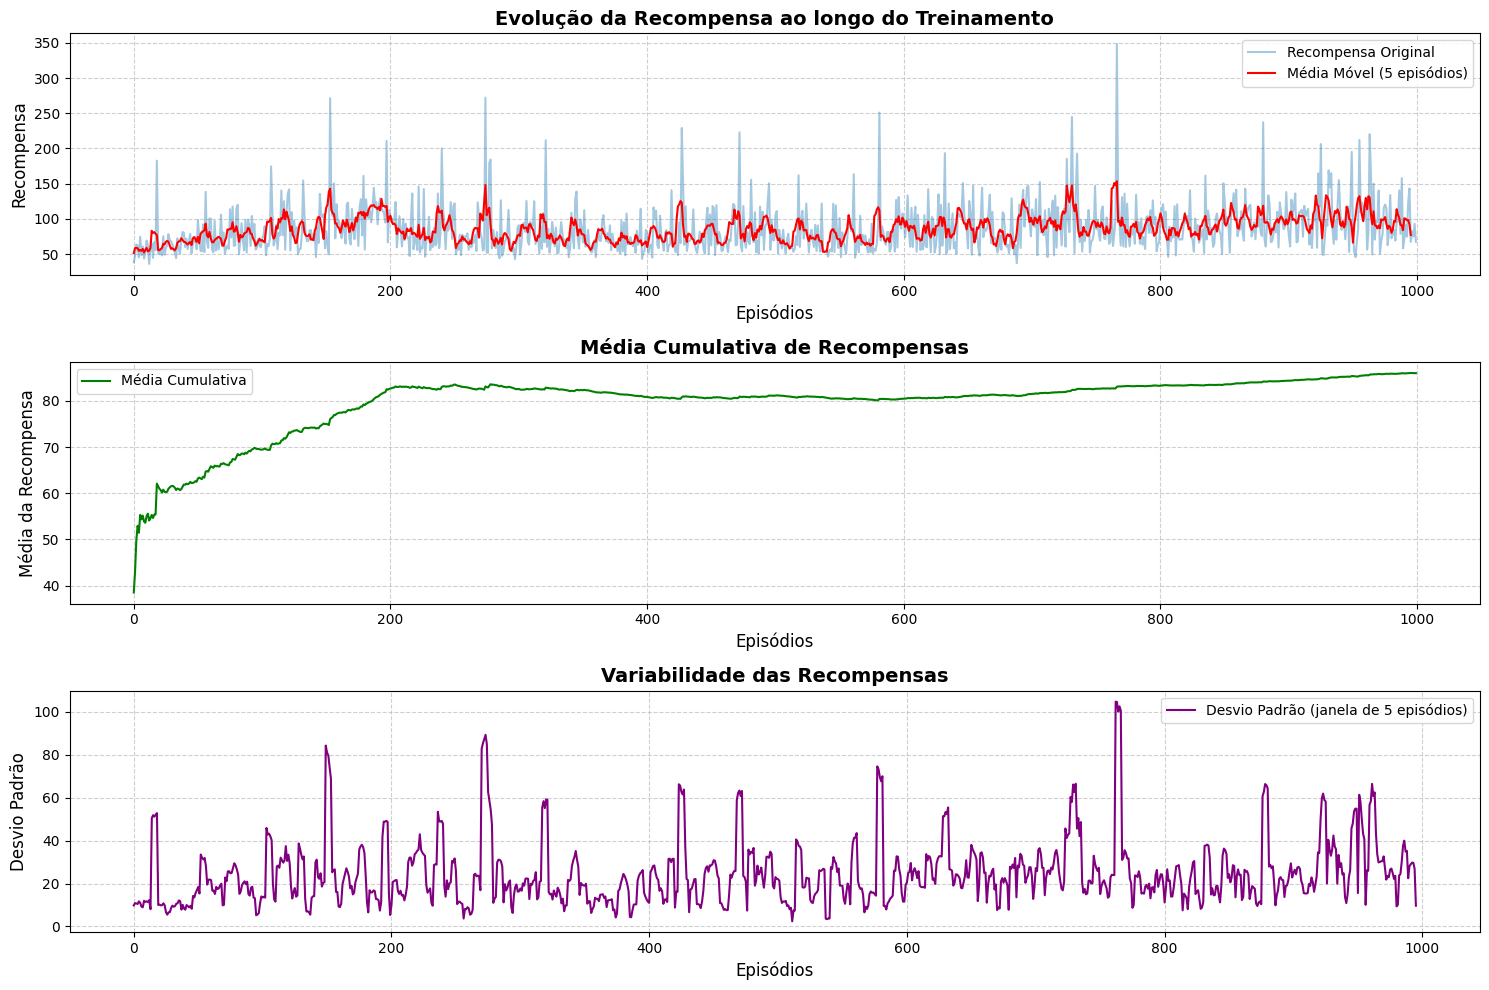

In [17]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Função para média móvel
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Supondo que rewardsX seja a lista com as recompensas de cada episódio
# Exemplo: rewardsX = [reward_ep1, reward_ep2, ..., reward_epN]
rewardsX = np.array(rewardsX)  # Garantir que é um array NumPy

# Cálculo da média móvel
window_size = 5
rewards_smooth = moving_average(rewardsX, window_size)

# Cálculo da média cumulativa
cumulative_mean = np.cumsum(rewardsX) / (np.arange(len(rewardsX)) + 1)

# Cálculo do desvio padrão móvel (variabilidade)
def moving_std(data, window_size=5):
    stds = []
    for i in range(len(data) - window_size + 1):
        stds.append(np.std(data[i:i+window_size]))
    return np.array(stds)
rewards_std = moving_std(rewardsX, window_size)

# Criar diretório para salvar os gráficos
os.makedirs('graficos', exist_ok=True)

# Criação dos subplots para visualizar diferentes métricas
plt.figure(figsize=(15,10))

# 1. Gráfico da Recompensa Original com Média Móvel
plt.subplot(3, 1, 1)
plt.plot(rewardsX, alpha=0.4, label="Recompensa Original")
plt.plot(range(len(rewards_smooth)), rewards_smooth, color="red", label="Média Móvel (5 episódios)")
plt.xlabel("Episódios", fontsize=12)
plt.ylabel("Recompensa", fontsize=12)
plt.title("Evolução da Recompensa ao longo do Treinamento", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# 2. Gráfico da Média Cumulativa de Recompensas
plt.subplot(3, 1, 2)
plt.plot(cumulative_mean, color="green", label="Média Cumulativa")
plt.xlabel("Episódios", fontsize=12)
plt.ylabel("Média da Recompensa", fontsize=12)
plt.title("Média Cumulativa de Recompensas", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# 3. Gráfico da Variabilidade (Desvio Padrão) com Janela Móvel
plt.subplot(3, 1, 3)
plt.plot(range(len(rewards_std)), rewards_std, color="purple", label="Desvio Padrão (janela de 5 episódios)")
plt.xlabel("Episódios", fontsize=12)
plt.ylabel("Desvio Padrão", fontsize=12)
plt.title("Variabilidade das Recompensas", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# Salvar os gráficos com timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/Salvo do Chrome/recompensas/recompensa_treinamento_{timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()
